In [ ]:
!pip install requests beautifulsoup4 pandas

In [ ]:
!pip install yfinance

## 1. Data Preparation
- Web scraping exchange rate data and save to a certain format.

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime

In [ ]:
class CurrencyMonitor:
    def __init__(self):
        self.fetch_exchange_rate()

    # update the url for the corresponding currency rate page, this only scraping CAD and CNY
    def fetch_exchange_rate(self):
        url = "https://g.co/finance/CAD-CNY"
        print("Fetching...")
        #headers = {}
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            soup_format = soup.prettify()
            #holders = soup.find_all('div', class_='YMlKec fxKbKc')
            div_element = soup.find('div', {'data-source':'CAD', 'data-target':'CNY'})
            print(div_element)
            if div_element:
                # print(div_element)
                last_price = div_element.get('data-last-price')
                last_market_timestamp = div_element.get('data-last-normal-market-timestamp')
                unix_timestamp = int(last_market_timestamp)
                last_timestamp_converted = datetime.fromtimestamp(unix_timestamp).strftime('%Y-%m-%d %H:%M:%S')
                print(f"The last price is: {last_price} for date: {last_timestamp_converted}")
                return(last_timestamp_converted, last_price)
            else:
                print("No matching element")
            # In case if you want to output the reponse to a separate file instead showing in terminal, uncomment below
            # print("Writing to the text file response.txt...")
            # f = open('response.txt', 'w')
            # f.write(soup_format)
            # f.close()

In [ ]:
CurrencyMonitor()

Fetching...
<div data-entity-type="3" data-last-normal-market-timestamp="1754626464" data-last-price="5.2274519999999995" data-mid="/g/11bvvxmsxg" data-source="CAD" data-target="CNY" data-tz-offset="0" jsaction="oFr1Ad:uxt3if;" jscontroller="NdbN0c" jsname="AS5Pxb"><div class="rPF6Lc" jsname="OYCkv"><div class="ln0Gqe"><div jsname="LXPcOd"><div class="AHmHk"><span class=""><div class="kf1m0" jsname="ip75Cb"><div class="YMlKec fxKbKc">5.2275</div></div></span></div></div><div jsname="CGyduf"></div></div></div><div class="ygUjEc" jsname="Vebqub">Aug 8, 4:14:24 AM UTC · <a href="https://www.google.com/intl/en-US_US/googlefinance/disclaimer/"><span class="koPoYd">Disclaimer</span></a></div></div>
The last price is: 5.2274519999999995 for date: 2025-08-08 04:14:24


In [ ]:
#google page only has real time data, need to go to yahoo finance for historical data
import yfinance as yf

# Get last 6 months of daily data
df = yf.download("CADCNY=X", start="2025-02-01", end="2025-08-01", interval='1d')
df = df[['Close']]
df.reset_index(inplace=True)
df.columns = ['Date', 'Rate']

df.to_csv("cad_cny_history.csv", index=False)
print(df.tail())

/tmp/ipython-input-3523705728.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("CADCNY=X", start="2025-02-01", end="2025-08-01", interval='1d')
[*********************100%***********************]  1 of 1 completed

          Date      Rate
122 2025-07-25  5.243906
123 2025-07-28  5.220485
124 2025-07-29  5.226109
125 2025-07-30  5.209860
126 2025-07-31  5.190529


In [ ]:
df.head()

,Date,Rate
0,2025-02-03,4.883466
1,2025-02-04,4.989753
2,2025-02-05,5.010937
3,2025-02-06,5.078317
4,2025-02-07,5.093781


## 2. Model Forecasting

### A. Using prophet: An open-source time series forecasting tool developed by Meta. It is a Bayesian statistical modelin.
- https://facebook.github.io/prophet/docs/quick_start.html

In [ ]:
!pip install prophet

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpba5dfjsc/lbv2uetk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpba5dfjsc/3u7upw6b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19026', 'data', 'file=/tmp/tmpba5dfjsc/lbv2uetk.json', 'init=/tmp/tmpba5dfjsc/3u7upw6b.json', 'output', 'file=/tmp/tmpba5dfjsc/prophet_modele5yj7y4v/prophet_model-20250808041607.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:16:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:16:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


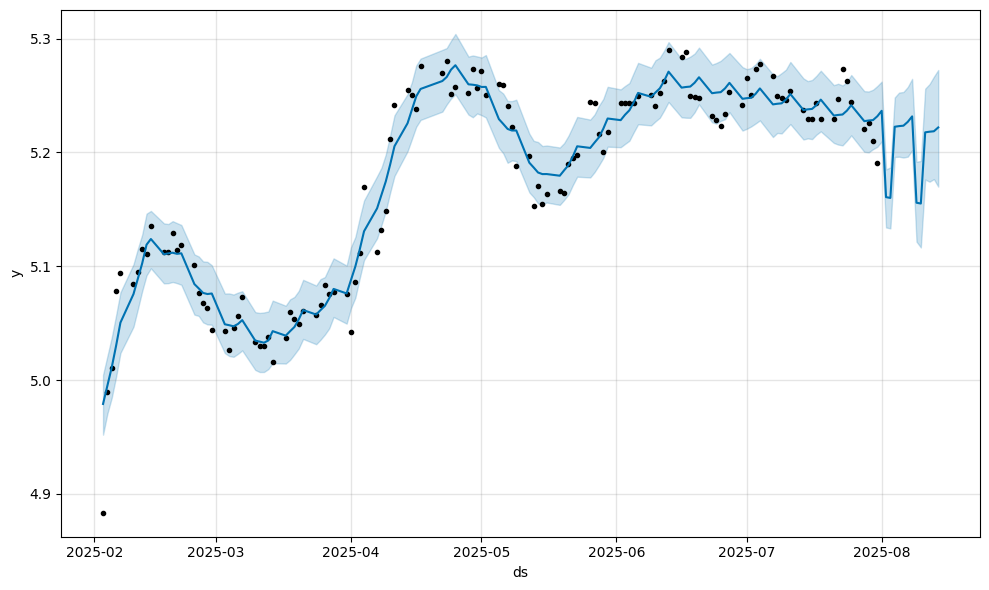

In [ ]:
from prophet import Prophet

# Load data
df = pd.read_csv('cad_cny_history.csv')
df = df[['Date', 'Rate']]
df.columns = ['ds', 'y']  # ds:datestamp, y:target value

# Model
model = Prophet()
model.fit(df)

# Forecast
future = model.make_future_dataframe(periods=14) #forecast 14 days
forecast = model.predict(future)

# Plot
fig = model.plot(forecast)

In [ ]:
forecast_14 = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
print(forecast_14)

            ds      yhat  yhat_lower  yhat_upper
0   2025-02-03  4.979065    4.952071    5.004572
1   2025-02-04  4.995211    4.970576    5.021063
2   2025-02-05  5.011180    4.984458    5.037397
3   2025-02-06  5.030143    5.002914    5.056876
4   2025-02-07  5.050540    5.023828    5.077102
..         ...       ...         ...         ...
136 2025-08-10  5.155130    5.116527    5.192476
137 2025-08-11  5.217662    5.176187    5.256011
138 2025-08-12  5.218215    5.174286    5.260028
139 2025-08-13  5.218591    5.176561    5.266522
140 2025-08-14  5.221961    5.169978    5.272417

[141 rows x 4 columns]


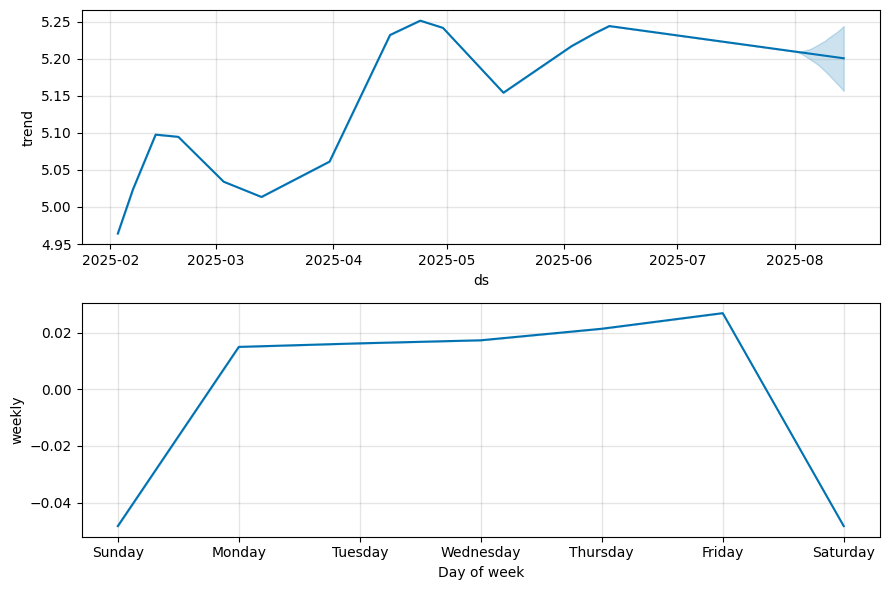

In [ ]:
fig2 = model.plot_components(forecast)

In [ ]:
# Interactive figure
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)

In [ ]:
start_rate = forecast['yhat'].iloc[-14-1]
end_rate = forecast['yhat'].iloc[-1]
rate_change = end_rate - start_rate
trend = "increase" if rate_change > 0 else "decrease" if rate_change < 0 else "remain stable"

start_day = forecast['ds'].iloc[-14-1]
end_day = forecast['ds'].iloc[-1]

summary = (
    f"The CAD to CNY exchange rate is forecasted to {trend} by "
    f"{abs(rate_change)/start_rate*100:.2f}% over the next 14 days, "
    f"from {start_rate:.4f} to {end_rate:.4f} for date: {start_day} to {end_day}."
)

print("Prediction Summary:")
print(summary)

Prediction Summary:
The CAD to CNY exchange rate is forecasted to decrease by 0.19% over the next 14 days, from 5.2318 to 5.2220 for date: 2025-07-31 00:00:00 to 2025-08-14 00:00:00.


### B. Using ARIMA
- see separate notebook

### C. Using LSTM/RNN/Transformer
- see separate notebook

## 3. Using LLM to explain insights of generated prediction results

In [3]:
# Install Hugging Face Transformers & Datasets
!pip install transformers accelerate bitsandbytes huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-c

In [1]:
from huggingface_hub import notebook_login
notebook_login()

- Code below reference to: https://huggingface.co/meta-llama/Llama-2-7b-chat-hf

In [ ]:
from huggingface_hub import login
login(new_session=False)

In [5]:
summary = "The CAD to CNY exchange rate is forecasted to decrease by 0.19% over the next 14 days, from 5.2318 to 5.2220 for date: 2025-07-31 00:00:00 to 2025-08-14 00:00:00."

In [2]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-generation", model="meta-llama/Llama-2-7b-chat-hf")

prompt = f"""You act a financial analyst, here is a exchange rate prediction made by a python project,
          Please take a look at the result {summary}, and provide more insightful explainations.
          """

messages = [
    {"role": "user", "content": prompt},
]
pipe(messages)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


OutOfMemoryError: CUDA out of memory. Tried to allocate 86.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 82.12 MiB is free. Process 52947 has 14.66 GiB memory in use. Of the allocated memory 14.52 GiB is allocated by PyTorch, and 13.30 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_name = "meta-llama/Llama-2-7b-chat-hf"  # change to any model you want

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

messages = [
    {"role": "user", "content": "Who are you?"},
]

inputs = tokenizer.apply_chat_template(
	messages,
	add_generation_prompt=True,
	tokenize=True,
	return_dict=True,
	return_tensors="pt",
).to(model.device)

outputs = model.generate(**inputs, max_new_tokens=40)
print(tokenizer.decode(outputs[0][inputs["input_ids"].shape[-1]:]))

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

> the session crashed after using all available GPUs. So will try using Hugging Face Ingerence API call.

### Using Inference API instead of local GPUs
- code reference for inference API: https://huggingface.co/meta-llama/Meta-Llama-3-8B-Instruct?inference_api=true&inference_provider=novita&language=python&client=openai

In [3]:
import os
os.environ['HF_TOKEN'] = ''

In [6]:
prompt = f"""You act a financial analyst, here is a exchange rate prediction made by a python project,
          Please take a look at the result {summary}, and provide more insightful explainations.
          """

In [7]:
import os
from huggingface_hub import InferenceClient

client = InferenceClient(
    provider="novita",
    api_key=os.environ["HF_TOKEN"],
)

completion = client.chat.completions.create(
    model="meta-llama/Meta-Llama-3-8B-Instruct",
    messages=[
        {
            "role": "user",
            "content": prompt
        }
    ],
)

print(completion.choices[0].message)

ChatCompletionOutputMessage(role='assistant', content="**Exchange Rate Forecast Analysis**\n\nThank you for providing the exchange rate prediction model output. As a financial analyst, I'll review the results and provide more insightful explanations.\n\n**Key Findings:**\n\n1. **CAD to CNY Exchange Rate Decrease:** The model predicts a decrease in the CAD to CNY exchange rate by 0.19% over the next 14 days. This indicates a slight downward trend in the Canadian dollar relative to the Chinese yuan.\n2. **Forecasted Exchange Rate:** The forecasted exchange rate for CAD to CNY on 2025-08-14 is 5.2220, down from the current rate of 5.2318.\n3. **Timeframe:** The prediction is made over a 14-day period, which is a relatively short-term forecast.\n\n**Insights:**\n\n1. **Market Sentiment:** The predicted decrease in the CAD to CNY exchange rate suggests a slightly bearish market sentiment for the Canadian dollar. This could be attributed to various economic factors, such as interest rate cha

In [8]:
print(completion.choices[0].message['content'])

**Exchange Rate Forecast Analysis**

Thank you for providing the exchange rate prediction model output. As a financial analyst, I'll review the results and provide more insightful explanations.

**Key Findings:**

1. **CAD to CNY Exchange Rate Decrease:** The model predicts a decrease in the CAD to CNY exchange rate by 0.19% over the next 14 days. This indicates a slight downward trend in the Canadian dollar relative to the Chinese yuan.
2. **Forecasted Exchange Rate:** The forecasted exchange rate for CAD to CNY on 2025-08-14 is 5.2220, down from the current rate of 5.2318.
3. **Timeframe:** The prediction is made over a 14-day period, which is a relatively short-term forecast.

**Insights:**

1. **Market Sentiment:** The predicted decrease in the CAD to CNY exchange rate suggests a slightly bearish market sentiment for the Canadian dollar. This could be attributed to various economic factors, such as interest rate changes, trade policies, or geopolitical events.
2. **Risk Management: